# Zachary Karate Club partitioning prediction

adapted from: https://docs.dgl.ai/en/0.4.x/tutorials/basics/1_first.html

In [272]:
import dgl
from dgl.nn.pytorch import GraphConv
import itertools
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
torch.manual_seed(2021)
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
sr = SummaryWriter('runs/zkc-separation')

%matplotlib inline

In [273]:
def build_karate_club_graph():
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    return dgl.DGLGraph((u, v))

G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


/home/weiss/.conda/envs/GNN/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


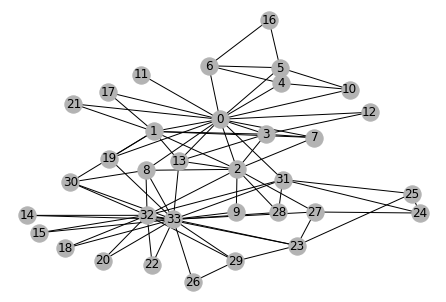

In [274]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [275]:
# we assign a learnable embedding vector for each node
embed = nn.Embedding(34, 8)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [276]:
# print Mr. Hi's initial feature
print(G.ndata['feat'][0])

# print node 10 and 20's input features
print(G.ndata['feat'][[10, 20]])

tensor([-0.1452,  0.9747,  0.6023,  1.5775,  0.5700,  0.4273, -0.0021, -1.6452],
       grad_fn=<SelectBackward>)
tensor([[-0.6841,  0.8239, -0.9060, -0.5604,  0.7763,  0.6427,  0.0368,  0.2074],
        [-0.5907,  0.3848, -0.7935, -0.1257, -2.0549, -0.9491, -2.1105, -0.7407]],
       grad_fn=<IndexBackward>)


In [277]:
# GCN model with two layers
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
        self.activation = nn.LeakyReLU()

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = self.activation(h)
        h = self.conv2(g, h)
        return h

net = GCN(8, 4, 2)

In [278]:
# Data preparation and initialization
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # Mr. Hi = 0; Officer = 33
labels = torch.tensor([1, 0])  # New club = 1; Old club = 0

In [279]:
# Train

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(31):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    sr.add_scalar("Loss/train", loss.item(), epoch)  # tensorboard

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.8079
Epoch 1 | Loss: 0.7681
Epoch 2 | Loss: 0.7306
Epoch 3 | Loss: 0.6965
Epoch 4 | Loss: 0.6646
Epoch 5 | Loss: 0.6336
Epoch 6 | Loss: 0.6040
Epoch 7 | Loss: 0.5752
Epoch 8 | Loss: 0.5469
Epoch 9 | Loss: 0.5191
Epoch 10 | Loss: 0.4922
Epoch 11 | Loss: 0.4659
Epoch 12 | Loss: 0.4413
Epoch 13 | Loss: 0.4181
Epoch 14 | Loss: 0.3951
Epoch 15 | Loss: 0.3740
Epoch 16 | Loss: 0.3563
Epoch 17 | Loss: 0.3380
Epoch 18 | Loss: 0.3196
Epoch 19 | Loss: 0.3014
Epoch 20 | Loss: 0.2836
Epoch 21 | Loss: 0.2664
Epoch 22 | Loss: 0.2497
Epoch 23 | Loss: 0.2335
Epoch 24 | Loss: 0.2176
Epoch 25 | Loss: 0.2021
Epoch 26 | Loss: 0.1865
Epoch 27 | Loss: 0.1708
Epoch 28 | Loss: 0.1557
Epoch 29 | Loss: 0.1413
Epoch 30 | Loss: 0.1278


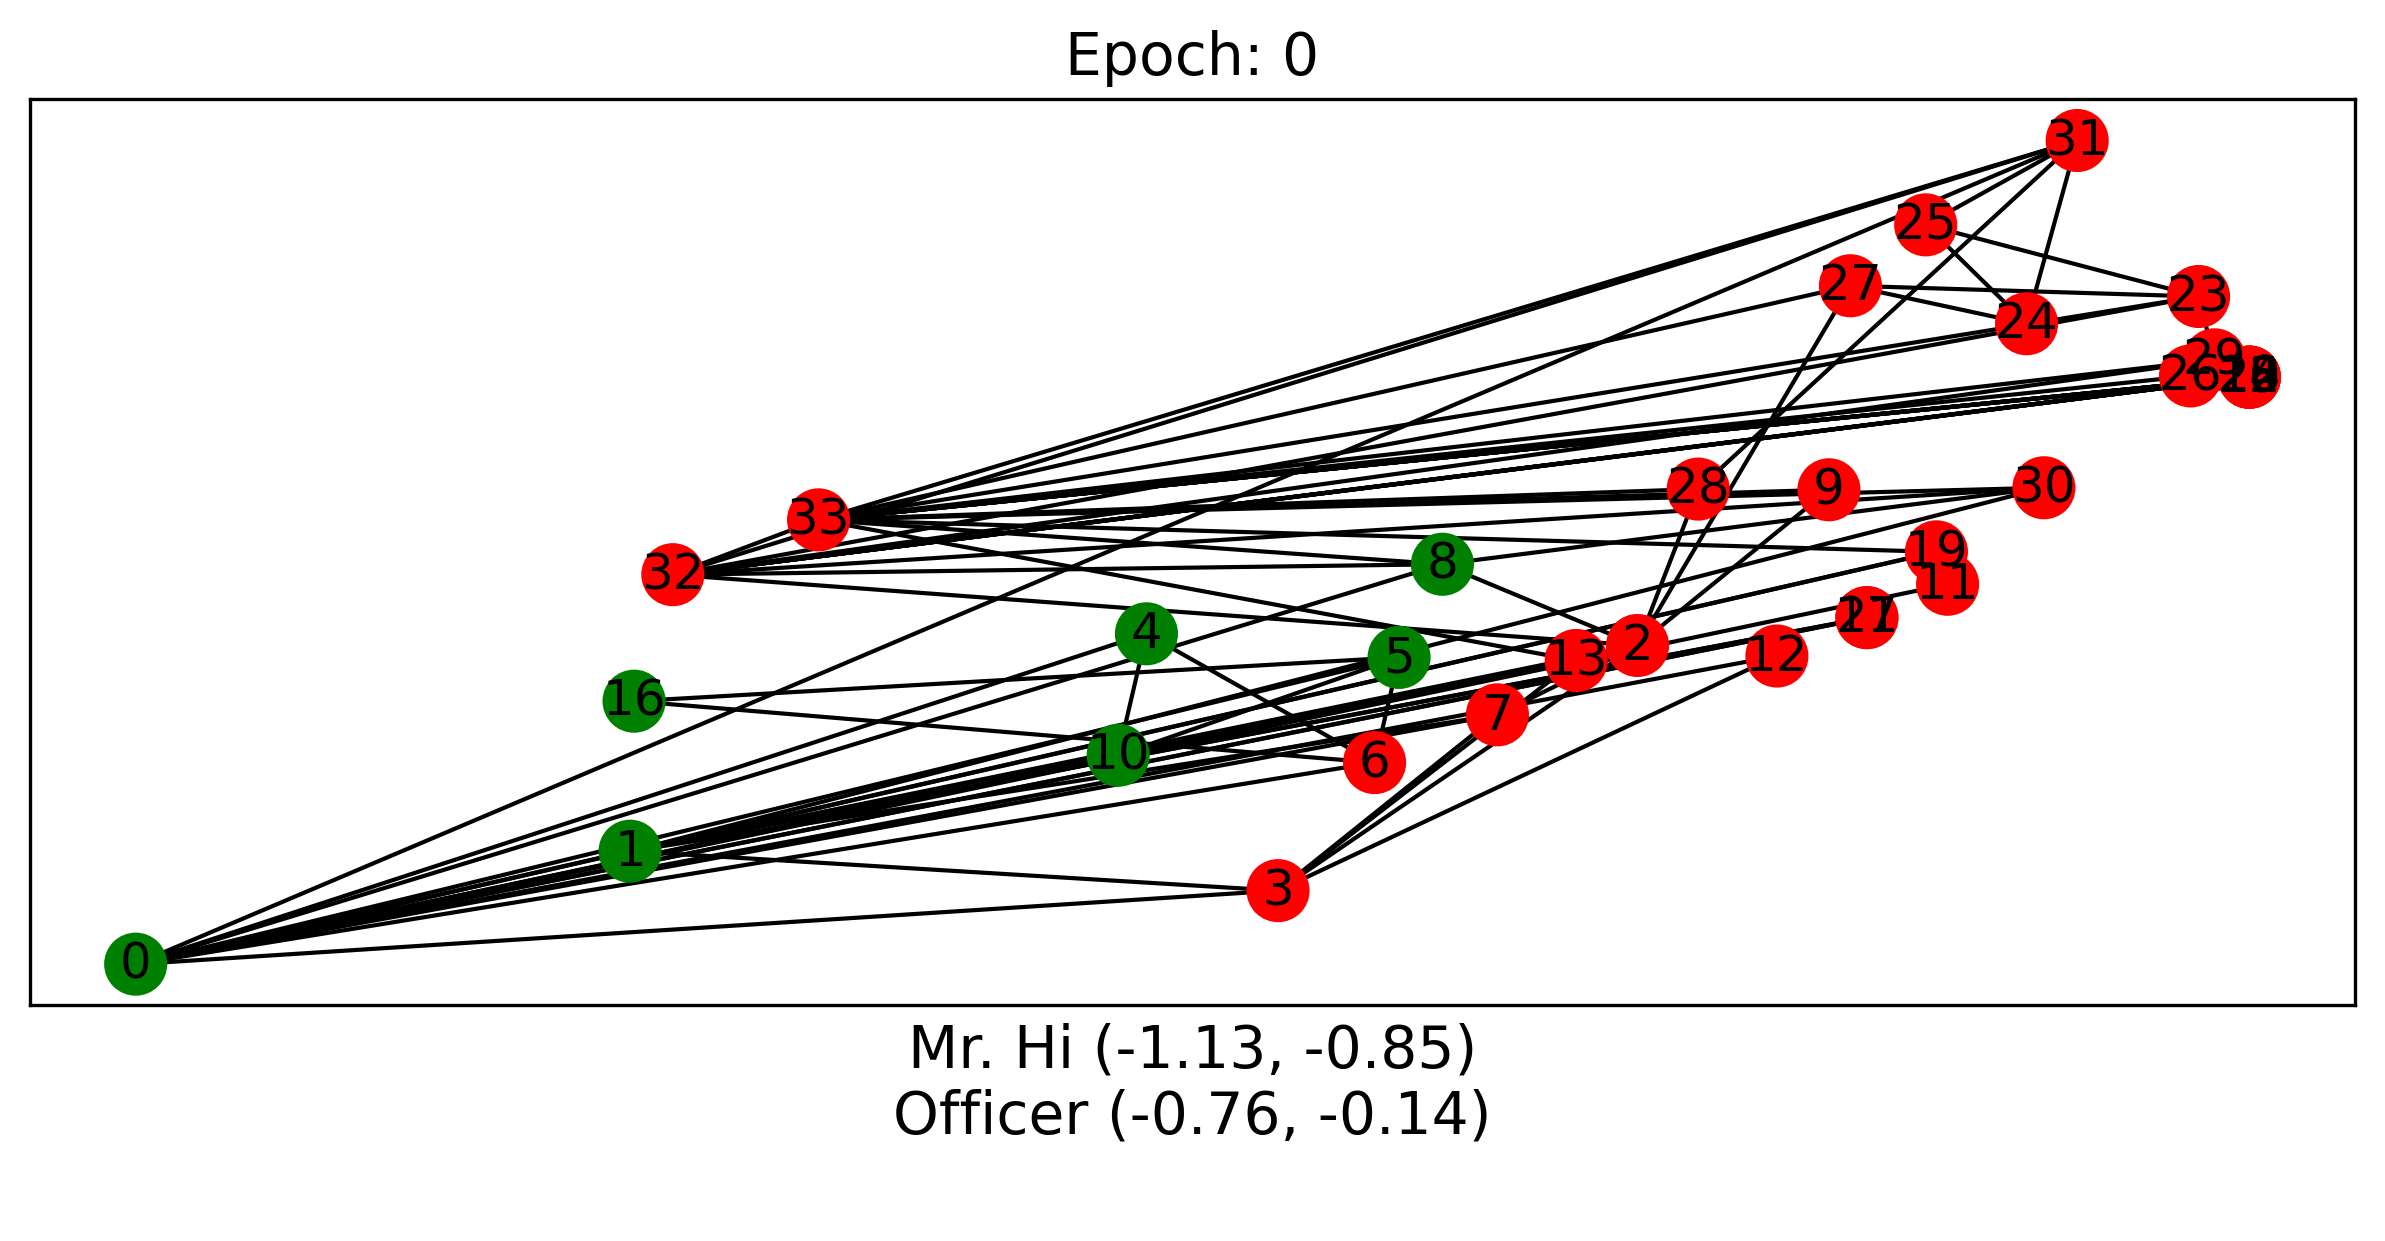

In [280]:
# Visualize
clubs = { 'Mr. Hi': 0, 'Officer': 1} # convert node attributes into labels (unnecessarily complicated..)
# get real clubs
G = nx.karate_club_graph()

def draw(i ,ax, node_size, axis='off'):
    cls1color = 'green'
    cls2color = 'yellow'
    cls3color = 'red'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()  # use feature (0 or 1) with highest log odds (or mark wrong categorized
        if  cls == clubs[G.nodes[v]["club"]]:
            colors.append(cls3color)
        else:
            colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis(axis)
    if axis == 'on':
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    ax.set_title('Epoch: %d' % i, fontsize= 14)
    ax.set_xlabel('Mr. Hi (%.2f, %.2f)\nOfficer (%.2f, %.2f)\n' %(pos[0][0], pos[0][1],pos[33][0], pos[33][1]), fontsize = 14)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=node_size, ax=ax)
fig = plt.figure(dpi=300, figsize=(10,4))
ax = fig.subplots()
draw(0, ax, 200, axis='On')  # draw the prediction of epoch i

class 0
[-1.1279476 -0.8528915]
[-3.0569026   0.17953727]
class 1
[-0.76410997 -0.14359315]
[ 0.5232008  -0.89413387]


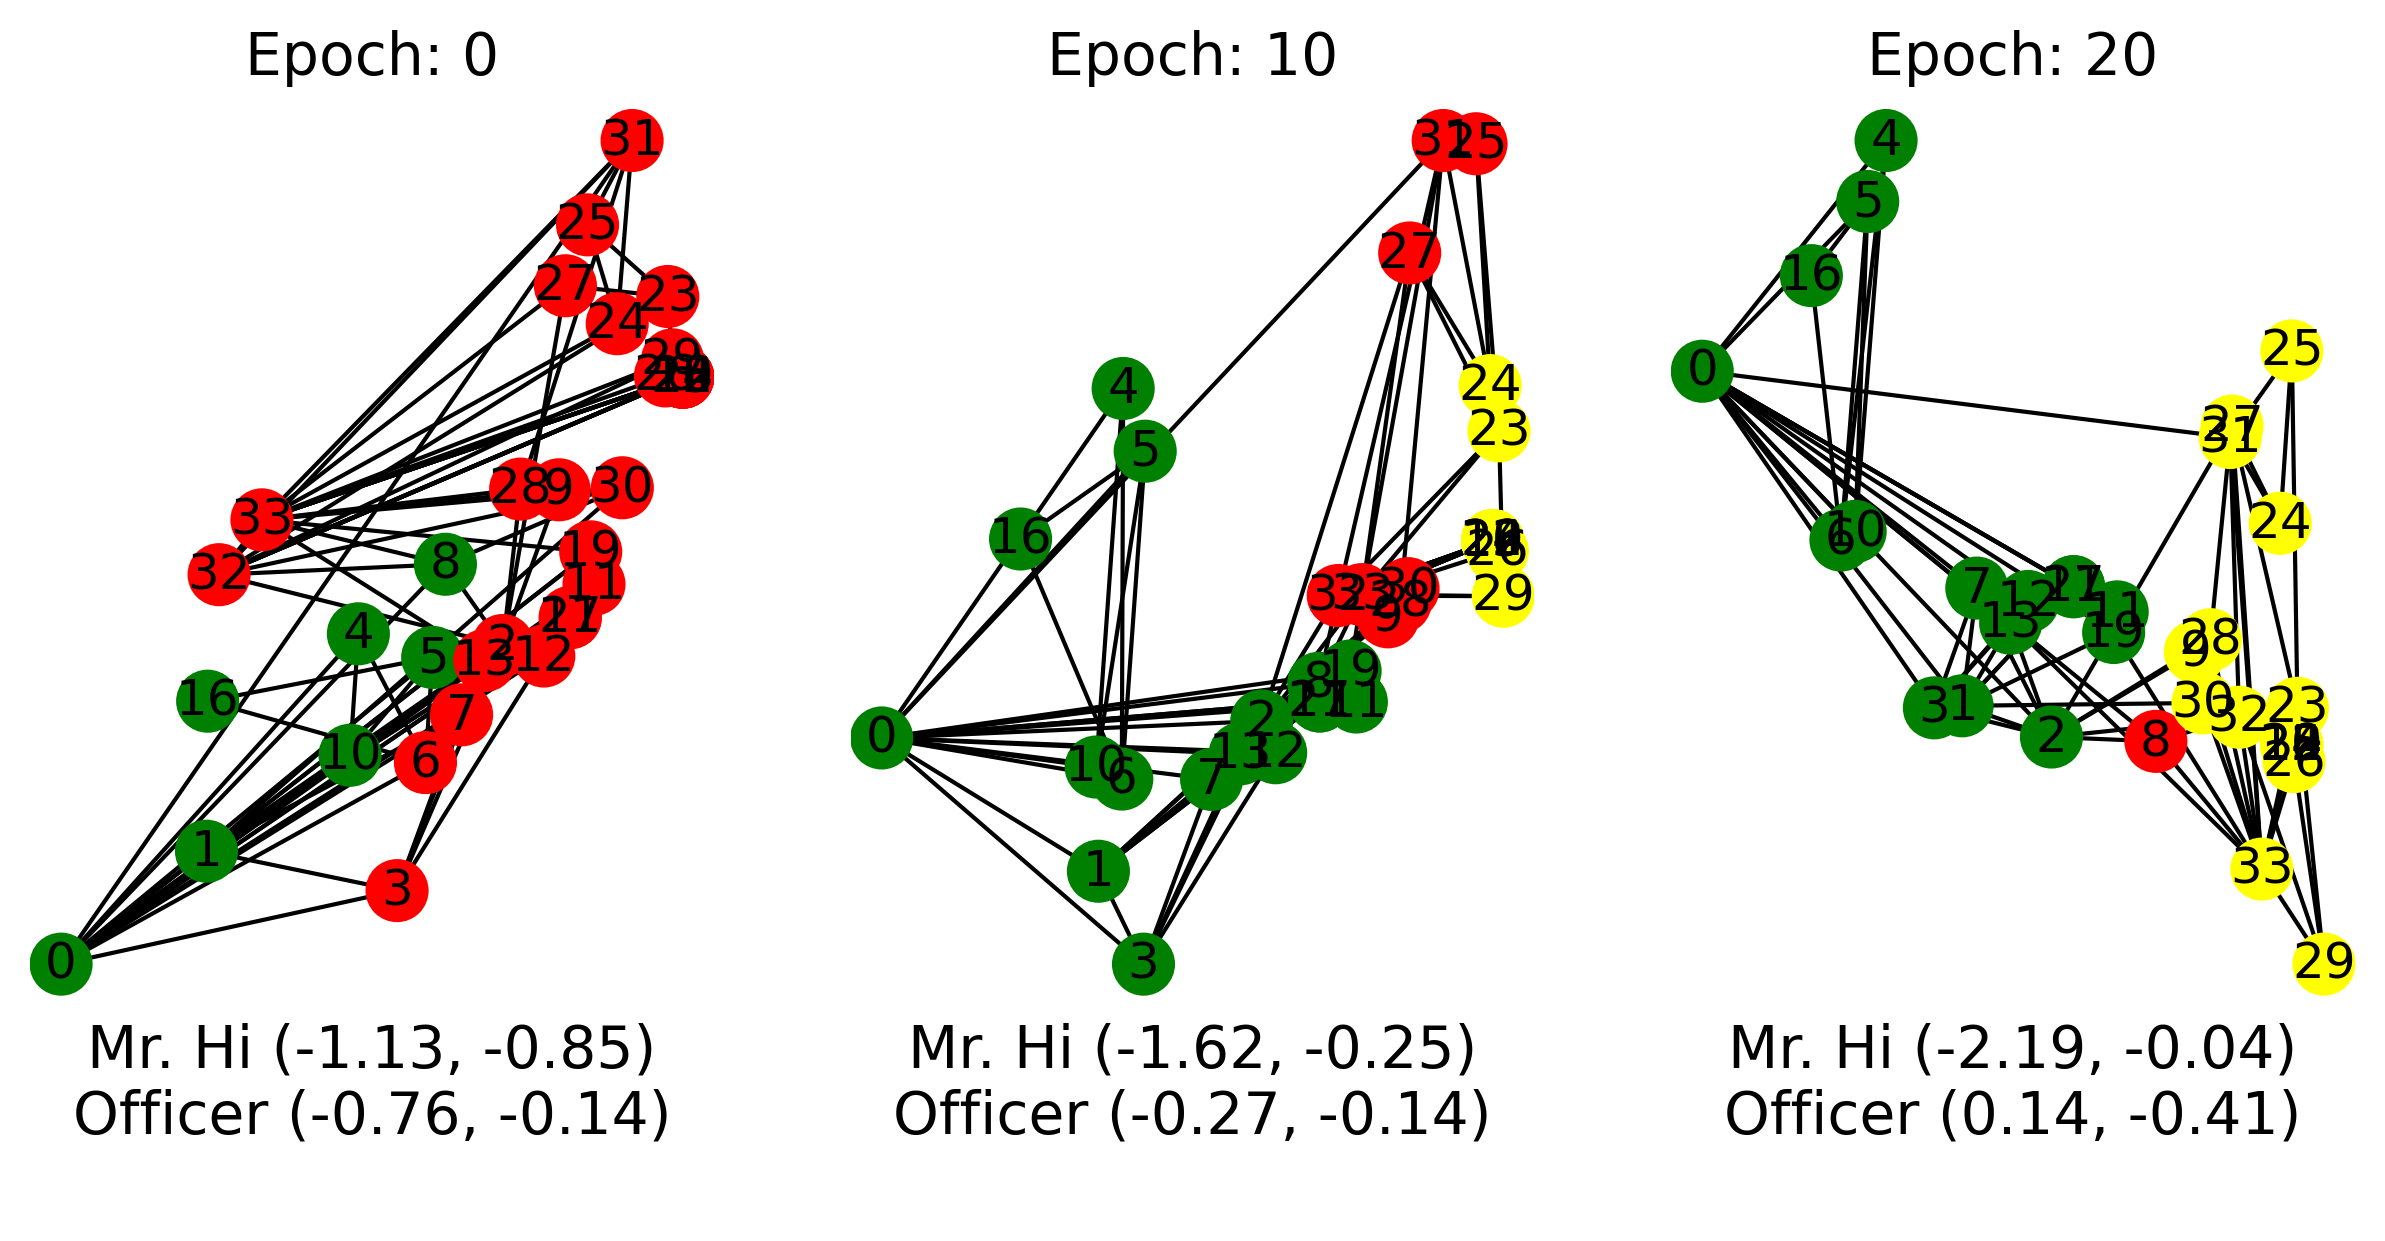

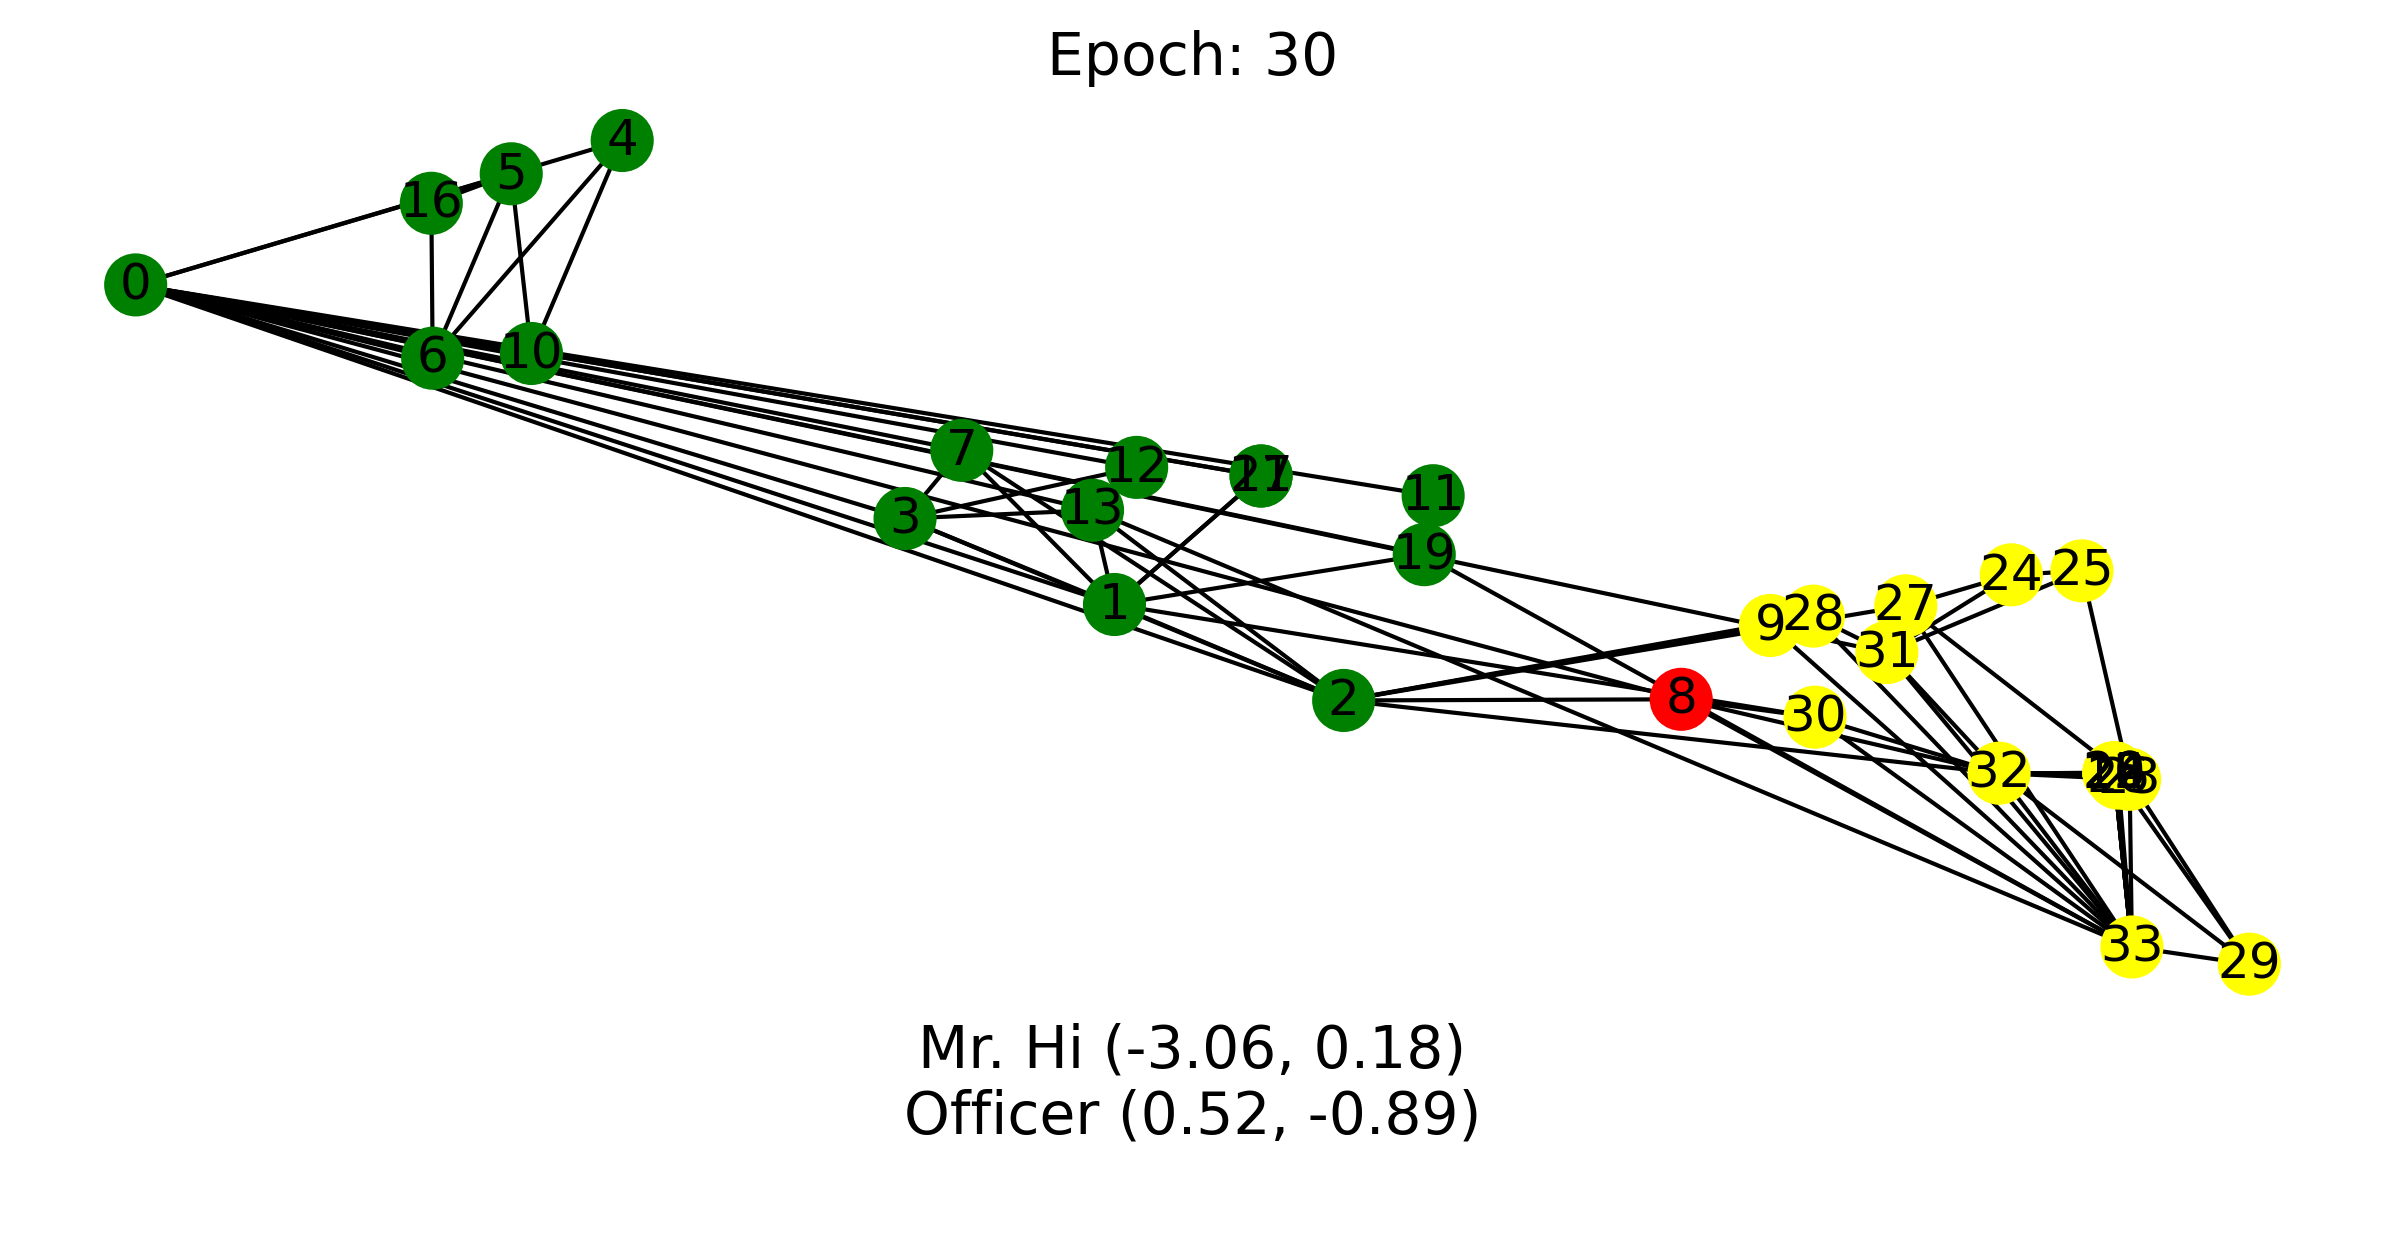

In [281]:
fig = plt.figure(dpi=300, figsize=(10,4))
ax = fig.subplots(ncols=3)
draw(0, ax[0], 200, axis='on')  # draw the prediction of epoch i
draw(10, ax[1], 200, axis='on')  # draw the prediction of epoch i
draw(20, ax[2], 200, axis='on')  # draw the prediction of epoch i
print('class 0')
print(all_logits[0][0].numpy())
print(all_logits[30][0].numpy())
print('class 1')
print(all_logits[0][33].numpy())
print(all_logits[30][33].numpy())

fig.savefig('/home/weiss/git/thesis/doc/figures/zkc-early-epochs.png', dpi=300)
fig = plt.figure(dpi=300, figsize=(10,4))
ax = fig.subplots()
draw(30, ax, 200, axis='on')  # draw the prediction of epoch i
fig.savefig('/home/weiss/git/thesis/doc/figures/zkc-final-epoch.png', dpi=300)

In [282]:
def draw_ani(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)


fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
# create all the frames
ani = animation.FuncAnimation(fig, draw_ani, frames=len(all_logits), interval=400)

# Set up formatting for the movie files
WriterClass = animation.writers['ffmpeg']
writer = WriterClass(fps=10, metadata=dict(artist='TW'), bitrate=1800)
ani.save('zkc-separation.mp4', writer=writer)
plt.close()

In [283]:
# I rather want a gif
writer = animation.ImageMagickWriter()
ani.save('zkc-separation.gif', writer=writer)

plt.close()

In [284]:
sr.close()  # close Tensorboard summary writer